In [2]:
#from sklearn.metrics import confusion_matrix
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,precision_score,recall_score,f1_score,accuracy_score
import seaborn as sns

In [3]:
# Reclassify the pixels into a single indicator:
def reclass_old(pixel):
    if np.array_equiv(pixel,np.array([16, 150, 24])):
        return 'sh'
    if np.array_equiv(pixel,np.array([51, 102, 204])):
        return 'sa'
    if np.array_equiv(pixel,np.array([220,  57, 18])):
        return 'g'
    if np.array_equiv(pixel,np.array([255, 153, 0])):
        return 'w'
    if np.array_equiv(pixel,np.array([0, 0, 0])):
        return 'o'
    if np.array_equiv(pixel,np.array([153, 0, 153])):
        return 'e'

In [4]:
def get_files_per_season(dir):
        file_list = [x for x in os.listdir(dir) if x[-3:]=='png']
        file_list.sort()
        seasons_dict = {'files':{'20180917':[],
                '20211013':[],
                '20180419':[],
                '20220302':[]},
                'dir':dir}
        for key in seasons_dict['files'].keys():
            seasons_dict['files'][key]=[x for x in file_list if key in x]
        return seasons_dict

In [5]:
# Reclassify the pixels into a single indicator:
px_dict = {190:'s',
           357:'z',
           295:'g',
           408:'w',
           0:'e',
           306:'o'}
def reclass(pixel, px_dict = px_dict):
    px = pixel.sum() # Convert into numerical value for ease of use.
    return px_dict[px]

In [6]:
# Concatenate images per dataset.
def concatenate_images(dict):
   reclass_dict = {}
   images = []
   for season in dict['files']:
      for file in dict['files'][season]:
         images.append(np.reshape(np.array(Image.open(dict['dir']+file)),[500**2,3]))
      concatenated = np.concatenate(images,axis=0)
      reclassified = np.apply_along_axis(reclass,axis = 1,arr=concatenated)
      reclass_dict.update({season:reclassified})
      images = []   
   return {'images':reclass_dict}

In [7]:
# Create a confusion matrix on the basis of actual and predicted values.
def create_cm(predicted,actual):
    cm = ConfusionMatrixDisplay.from_predictions(actual,
                                                 predicted,
                                                 values_format='.2f',#Fix formatting so that consistently have 2 decimal places.
                                                 labels = ['o','w','g','z','s'],#leave out 'e' as this relates to errors/non-predictions
                                                 display_labels=['Other','White','Grey','Sand','Shrubs'],# Change labels to be more descriptive
                                                 normalize='pred')
    plt.close()
    return cm

In [ ]:
ConfusionMatrixDisplay.from_predictions()

In [8]:
# Create confusion matrices based on aggregated data.
def aggregate_cms(pred_dict,actual_dict):
    
    # Create aggregate autumn datasets:
    aut_pred = np.concatenate([pred_dict['images']['20180917'],pred_dict['images']['20211013']])
    aut_actual = np.concatenate([actual_dict['images']['20180917'],actual_dict['images']['20211013']])

    # Aggregate spring datasets:
    spr_pred = np.concatenate([pred_dict['images']['20180419'],pred_dict['images']['20220302']])
    spr_actual = np.concatenate([actual_dict['images']['20180419'],actual_dict['images']['20220302']])

    # Creating overall datasets:
    overall_pred = np.concatenate([aut_pred,spr_pred])
    overall_actual = np.concatenate([aut_actual,spr_actual])

# Overall excluding training dataset:
    testing_pred = np.concatenate([pred_dict['images']['20211013'],pred_dict['images']['20220302']])
    testing_actual = np.concatenate([actual_dict['images']['20211013'],actual_dict['images']['20220302']])

    aut_cm = create_cm(aut_pred,aut_actual)
    spr_cm = create_cm(spr_pred,spr_actual)
    overall_cm = create_cm(overall_pred,overall_actual)
    testing_cm = create_cm(testing_pred,testing_actual)

    cms = {'autumn':aut_cm,
           'spring':spr_cm,
           'overall':overall_cm,
           'testing':testing_cm}
    
    return cms




In [9]:
# Create confusion matrices for dictionaries specified.
def create_cm_dict(actual_dict,pred_dict):
    rename_seasons = {'20180419':'spring_2018',
                      '20180917':'autumn_2018',
                      '20211013':'autumn_2021',
                      '20220302':'spring_2022'}
    cm_dict = {}
    for season in actual_dict['images']:
        cm = ConfusionMatrixDisplay.from_predictions(actual_dict['images'][season],
                                                 pred_dict['images'][season],
                                                 values_format='.2f',#Fix formatting so that consistently have 2 decimal places.
                                                 labels = ['o','w','g','z','s'],#leave out 'e' as this relates to errors/non-predictions
                                                 display_labels=['Other','White','Grey','Sand','Shrubs'],# Change labels to be more descriptive
                                                 normalize='pred')
        plt.close()
        cm_dict.update({rename_seasons[season]:cm})
        
    return {'cms':cm_dict}

In [10]:
# Ensure that the predicted file lists are complete and ordered in the same way as the actual file list.
def completeness_check(actual_dict, pred_dict):
    for key in actual_dict['files'].keys():
        actual_code = ['_'.join(x.split("_")[0:4]) for x in actual_dict['files'][key]]
        pred_code = ['_'.join(x.split("_")[0:4]) for x in pred_dict['files'][key]]
        if(actual_code==pred_code):
            print('all good in the hood')
        else:
            print('file lists do not match')

In [56]:
# Plot confusion matrices.
def plot_cms(dicts,season):
    fig, ax = plt.subplots(nrows=2,ncols=2, sharex=True,sharey = True, figsize = [9,8])
    a = dicts[2]['cms'][season].plot(ax=ax[0,0],values_format = '.2f').ax_.get_images()[0]
    ax[0,0].set_title(' '.join(dicts[2]['model'].split('_')).title()+' Model')#Change to title case
    a.colorbar.remove()
    a.set_clim(0,1)

    b = dicts[4]['cms'][season].plot(ax=ax[1,0],values_format = '.2f').ax_.get_images()[0]
    ax[1,0].set_title(' '.join(dicts[4]['model'].split('_')).title()+' Model')
    b.colorbar.remove()
    b.set_clim(0,1)

    c = dicts[3]['cms'][season].plot(ax=ax[1,1],values_format = '.2f').ax_.get_images()[0]
    ax[1,1].set_title(' '.join(dicts[3]['model'].split('_')).title()+' Model')
    c.colorbar.remove()
    c.set_clim(0,1)

    d = dicts[1]['cms'][season].plot(ax=ax[0,1],values_format = '.2f').ax_.get_images()[0]
    ax[0,1].set_title(' '.join(dicts[1]['model'].split('_')).title()+' Model')
    d.colorbar.remove()
    d.set_clim(0,1)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.11, 0.03, 0.767]) #left, bottom, width, height as % of total figure.
    fig.colorbar(a.set_clim(0,1),cax=cbar_ax)
    fig.suptitle(f'Model Performance: {season.title()} Data', fontsize=13,fontweight='bold') # Conver to title case.
    plt.subplots_adjust(hspace = 0.25)
    
    fig.savefig(season+'.png') # Save result.

Actual script starts here.

In [12]:
# Read in the required files.
actuals_dir = './actuals/'
aut_model_dir = './predictions/aut_model/'
spr_model_dir = './predictions/spr_model/'
large_model_dir = './predictions/combined_large/'
small_model_dir = './predictions/combined_small/'

# Put directories into list
dirs = [actuals_dir,aut_model_dir,spr_model_dir,large_model_dir,small_model_dir]

models = ['autumn_2018','spring_2018','large_combined','small_combined']

# Put dictionaries into list and populate with image names per season.
actual_dict,aut_dict,spr_dict,large_dict,small_dict = [get_files_per_season(x) for x in dirs]

# Put dicts into list.
dicts = [actual_dict,aut_dict,spr_dict,large_dict,small_dict]

# Do the completeness check on the dictionaries.
[completeness_check(x,actual_dict) for x in dicts[1:]]

# Add concatenated images to dictionaries.
[x.update(concatenate_images(x)) for x in dicts]

# Create confusion matrices for each model.
[x.update(create_cm_dict(actual_dict,x)) for x in dicts]

# Create aggregated confusion matrices for each model:
[x['cms'].update(aggregate_cms(x,actual_dict)) for x in dicts]

# Add model names to dictionaries (terrible but it totally works!):
i = 0
for dict in dicts[1:]:
    dict.update({'model':models[i]})
    i +=1

all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood
all good in the hood


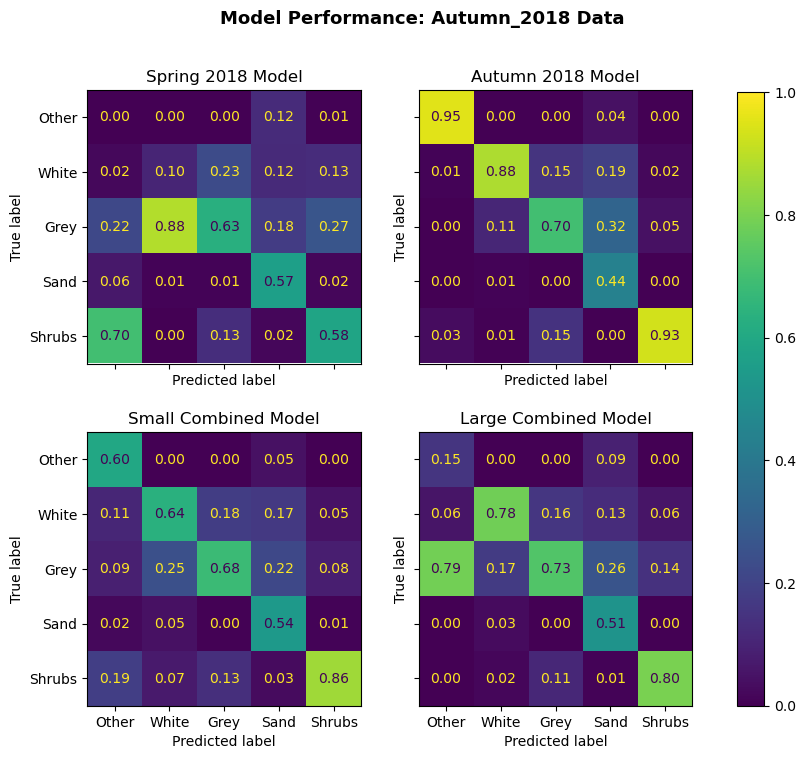

In [64]:
plot_cms(dicts,'autumn_2018')

This is for plotting the specifications of the histograms of the testing datasets:

In [14]:
# Get classification counts from each season:
a = np.unique(actual_dict['images']['20180917'],return_counts = True)
b = np.unique(actual_dict['images']['20211013'],return_counts = True)
c = np.unique(actual_dict['images']['20180419'],return_counts = True)
d = np.unique(actual_dict['images']['20220302'],return_counts = True)

# Convert into combined testing data dictionary
test = {}

test['Autumn 2018 Testing'] = {label: value for label,
            value in zip(a[0], a[1])}

test['Autumn 2021 Testing'] = {label: value for label,
            value in zip(b[0], b[1])}

test['Spring 2018 Testing'] = {label: value for label,
            value in zip(c[0], c[1])}

test['Spring 2022 Testing'] = {label: value for label,
            value in zip(d[0], d[1])}


In [15]:
# Create dictionaries of training data
train_aut_2018 = {}
train_spr_2018 = {}

# Add directory information
train_aut_2018['dir'] = '../annotated/autumn/'
train_spr_2018['dir'] = '../annotated/spring/'

# Populate with relevant filenames
train_aut_2018['files'] = {'20180917':[x for x in os.listdir(train_aut_2018['dir']) if x[-3:] == 'png']}
train_spr_2018['files'] = {'20180419':[x for x in os.listdir(train_spr_2018['dir']) if x[-3:] == 'png']}

# Concatenate images and add to dictionary
train_aut_2018.update(concatenate_images(train_aut_2018))
train_spr_2018.update(concatenate_images(train_spr_2018))

# Get classification counts per season:
aut_counts = np.unique(train_aut_2018['images']['20180917'], return_counts = True)
spr_counts = np.unique(train_spr_2018['images']['20180419'], return_counts = True)

# Create combined dictionary of classification counts for plotting
train = {}
train['Autumn 2018 Training'] = {label: value for label,
            value in zip(aut_counts[0], aut_counts[1])}

train['Spring 2018 Training'] = {label: value for label,
            value in zip(spr_counts[0], spr_counts[1])}

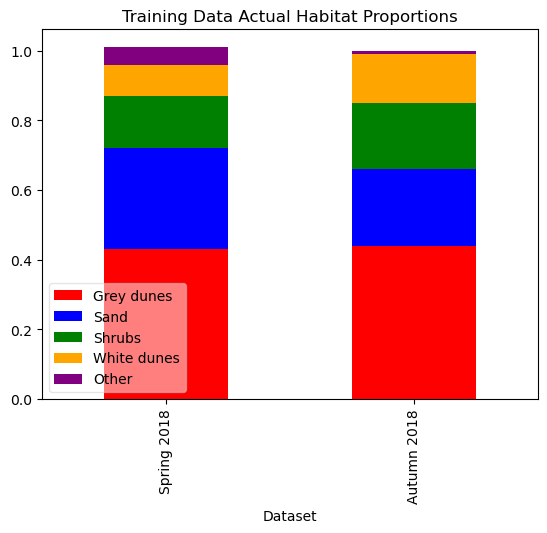

In [51]:
df_train = pd.DataFrame.from_dict(train, orient = 'index').rename(columns = {'g':'Grey dunes','s':'Shrubs','w':'White dunes','z':'Sand'})
df_train['Other'] = df_train['o']
df_train = df_train.drop(['e','o'], axis = 1)

# Fix ordering
df_train = df_train[["Grey dunes","Sand","Shrubs",'White dunes',"Other"]]

df_train_rounded = round(df_train/(500**2*102),2)
df_train_rounded = df_train_rounded.rename({'Autumn 2018 Training': 'Autumn 2018','Spring 2018 Training': 'Spring 2018'}, axis = 0)

ind = df_train_rounded.index.rename('Dataset')
df_train_rounded = df_train_rounded.set_index(ind)
df_train_rounded = df_train_rounded.sort_values(by = 'Dataset', ascending = False)

ax = df_train_rounded.plot.bar(stacked = True, color = ['red','blue','green','orange', 'purple'])

ax.set_title('Training Data Actual Habitat Proportions')

ax.legend(framealpha = 0.5)


In [50]:
df_train_rounded

,Grey dunes,Sand,Shrubs,White dunes,Other
Dataset,,,,,
Autumn 2018,0.44,0.22,0.19,0.14,0.01
Spring 2018,0.43,0.29,0.15,0.09,0.05


,Grey dunes,Sand,Shrubs,White dunes,Other
Dataset,,,,,
Spring 2018,0.43,0.29,0.15,0.09,0.05
Autumn 2018,0.44,0.22,0.19,0.14,0.01


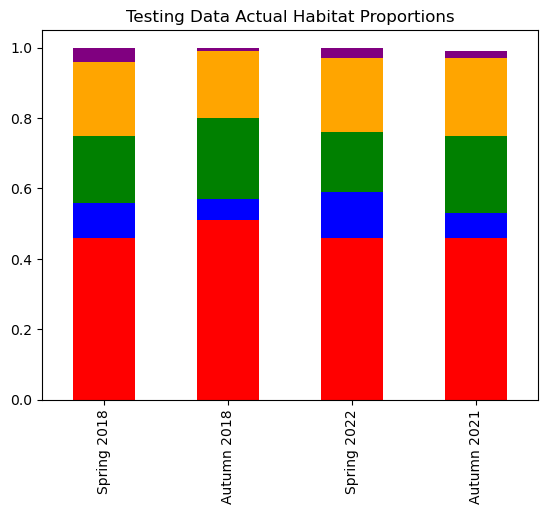

In [27]:
import pandas as pd
from matplotlib.patches import Patch

#Read in dictionaries as data frame and rename
df = pd.DataFrame.from_dict(test, orient = 'index').rename(columns = {'g':'Grey dunes','s':'Shrubs','w':'White dunes','z':'Sand'})

# Rename and reoder other column
df['Other'] = df['o']
df = df.drop(['o','e'], axis = 1)
df = df[["Grey dunes","Sand","Shrubs",'White dunes',"Other"]]

df_rounded = round(df/3750000,2)
df_rounded = df_rounded.rename({'Autumn 2018 Testing': 'Autumn 2018','Autumn 2021 Testing': 'Autumn 2021','Spring 2018 Testing': 'Spring 2018','Spring 2022 Testing': 'Spring 2022'}, axis = 0)

# Making order consistent
df_sorted = pd.concat([df_rounded.iloc[[2]],df_rounded.iloc[[0]],df_rounded.iloc[[3]],df_rounded.iloc[[1]]])

ax_test = df_sorted.plot.bar(stacked = True, color = ['red','blue','green','orange', 'purple'])

ax_test.set_title('Testing Data Actual Habitat Proportions')

ax_test.legend(framealpha = 0.5)

ax_test.get_legend().remove()


In [ ]:
df_

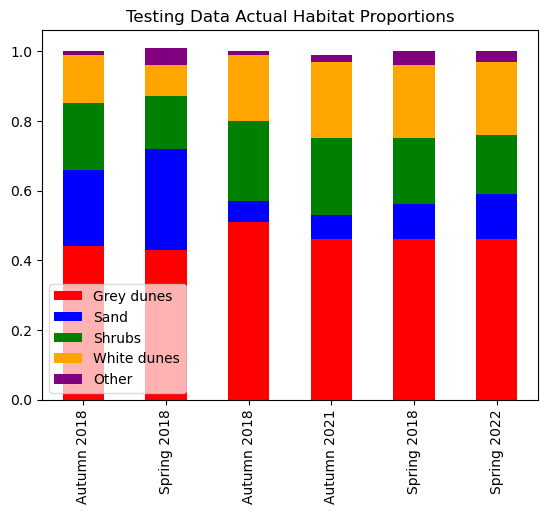

In [28]:
combined = pd.concat([df_train_rounded,df_rounded ], axis = 0)

ax_combined = combined.plot.bar(stacked = True, color = ['red','blue','green','orange', 'purple'])

ax_combined.set_title('Testing Data Actual Habitat Proportions')

ax_combined.legend(framealpha = 0.7)

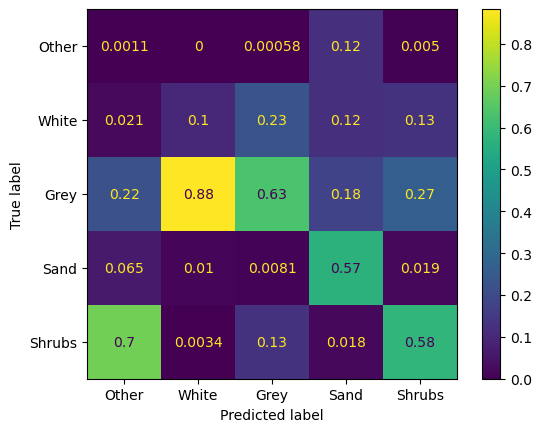

In [79]:
# Calculate f1 scores and accuracy:
def calc_metrics(actual, predicted):
    labels = ['o','w','g','z','s']
    f1_per_class = f1_score(actual,predicted, average = None, labels = labels)
    f1_weighted = f1_score(actual,predicted, average = 'weighted')
    accuracy = accuracy_score(actual,predicted)

    #labels = ['o','w','g','z','s']
    metrics = {}
    metrics['f1_score'] = f1_weighted.round(2)
    #f1_scores = zip(labels,f1_per_class.round(2))

    #for i,score in enumerate(f1_scores):
    #    metrics[labels[i]] = score[1]
    metrics['accuracy'] = accuracy.round(2)
    return metrics

In [82]:
# Metrics for individual months:
for period in actual_dict['images'].keys():
    for dict in dicts[1:]:
        dict['metrics'].update({period:calc_metrics(actual_dict['images'][period],dict['images'][period])})
        

In [84]:
# Combined metrics
actual_overall = np.concatenate([x for x in actual_dict['images'].values()])
for dict in dicts[1:]:
    pred_overall = np.concatenate([x for x in dict['images'].values()])
    dict['metrics']['overall']=calc_metrics(actual_overall,pred_overall)

In [85]:
# Overall: 2021/2022 only
actual_overall_202x = np.concatenate([actual_dict['images']['20211013'],actual_dict['images']['20220302']])
for dict in dicts[1:]:
    pred_overall_202x = np.concatenate([dict['images']['20211013'],dict['images']['20220302']])
    dict['metrics']['overall_2022']=calc_metrics(actual_overall_202x,pred_overall_202x)

In [86]:
df = pd.DataFrame()
for dict in dicts[1:]:
    a = pd.DataFrame(dict['metrics'])
    a['Model']=dict['model']
    df = pd.concat([df,a])
df = df.rename({'20180917':'Autumn_2018','20211013':'Autumn_2021','20180419':'Spring_2018','20220302':'Spring_2022'}, axis = 1)
df = df.reset_index()
df_melted = df.melt(id_vars=['index','Model'])
df_melted = df_melted.rename({'variable':'Dataset','index':'Measure','value':'Score'},axis = 1)
df_melted['Measure']=df_melted['Measure'].replace({'f1_score':'f1_total','o':'f1_other','w':'f1_white','g':'f1_grey','z':'f1_sand','s':'f1_shrub'})
df_melted['Dataset'] = df_melted['Dataset'].replace('overall','Overall')
df_melted['Dataset'] = df_melted['Dataset'].replace('overall_2022','Overall_2022')


In [92]:
df_melted

,Measure,Model,Dataset,Score
0,f1_total,autumn_2018,Spring_2022,0.28
1,accuracy,autumn_2018,Spring_2022,0.32
2,f1_total,spring_2018,Spring_2022,0.44
3,accuracy,spring_2018,Spring_2022,0.48
4,f1_total,large_combined,Spring_2022,0.46
5,accuracy,large_combined,Spring_2022,0.51
6,f1_total,small_combined,Spring_2022,0.49
7,accuracy,small_combined,Spring_2022,0.53
8,f1_total,autumn_2018,Autumn_2018,0.69
9,accuracy,autumn_2018,Autumn_2018,0.71


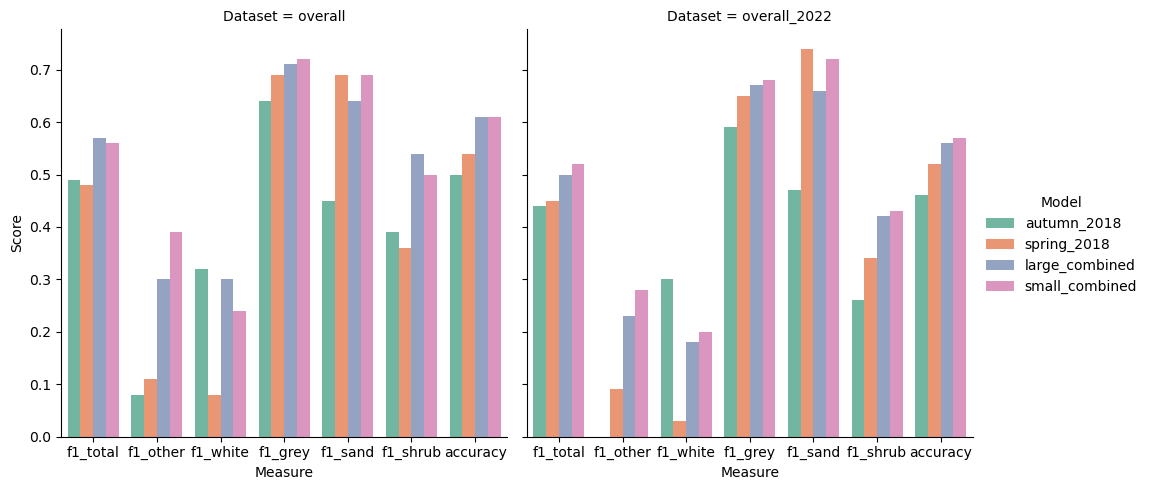

In [303]:
# Make the plot:
sns.catplot(data = df_melted[df_melted['Dataset'].apply(lambda x: 'overall' in x)], x='Measure',y='Score',hue='Model',col='Dataset',kind='bar', col_wrap=2,palette='Set2')

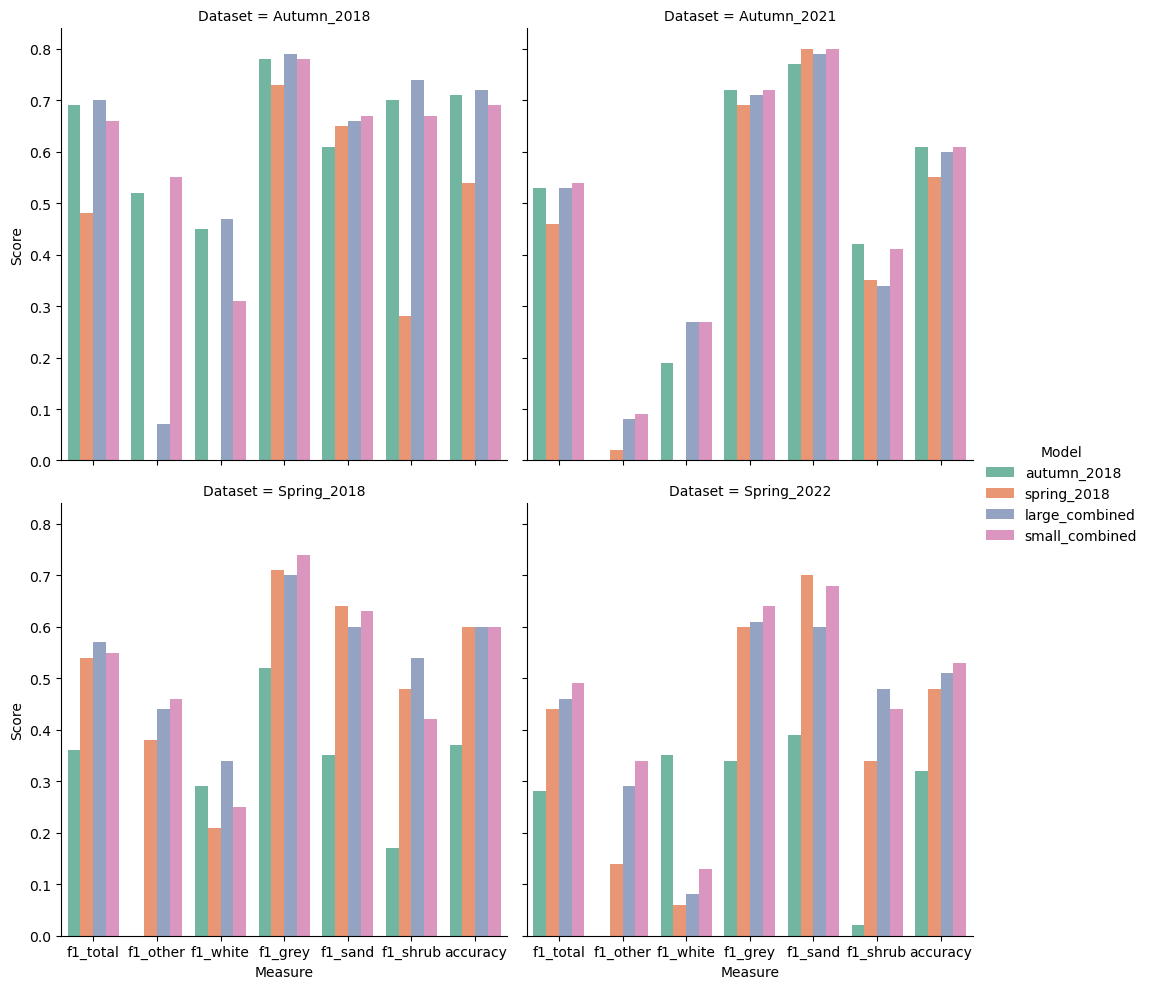

In [304]:
# Make the plot:
sns.catplot(data = df_melted[df_melted['Dataset'].apply(lambda x: 'overall' not in x)], x='Measure',y='Score',hue='Model',col='Dataset',kind='bar', col_wrap=2,palette='Set2')

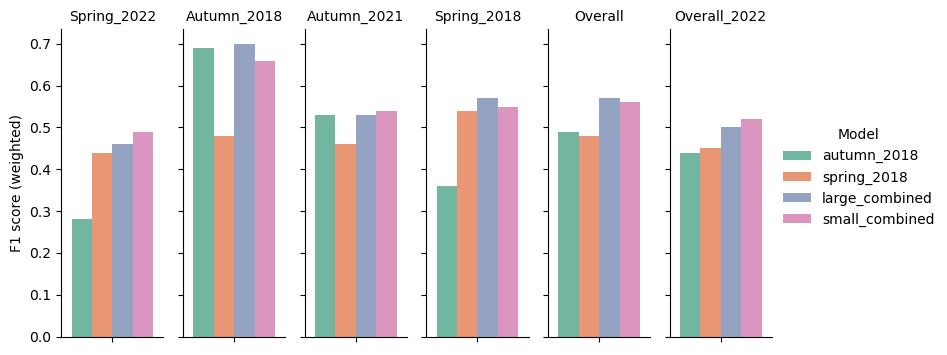

In [93]:
p = sns.catplot(data = df_melted[(df_melted['Measure'] == 'f1_total')], x='Measure',y='Score',hue='Model',col='Dataset',kind='bar',palette='Set2', height = 4, aspect = 1/3, margin_titles=False)
p.set_axis_labels('','F1 score (weighted)')
p.set_xticklabels('')
p.set_titles("{col_name}")


In [112]:
df_melted

,Measure,Model,Dataset,Score
0,f1_total,autumn_2018,Spring_2022,0.28
1,accuracy,autumn_2018,Spring_2022,0.32
2,f1_total,spring_2018,Spring_2022,0.44
3,accuracy,spring_2018,Spring_2022,0.48
4,f1_total,large_combined,Spring_2022,0.46
5,accuracy,large_combined,Spring_2022,0.51
6,f1_total,small_combined,Spring_2022,0.49
7,accuracy,small_combined,Spring_2022,0.53
8,f1_total,autumn_2018,Autumn_2018,0.69
9,accuracy,autumn_2018,Autumn_2018,0.71


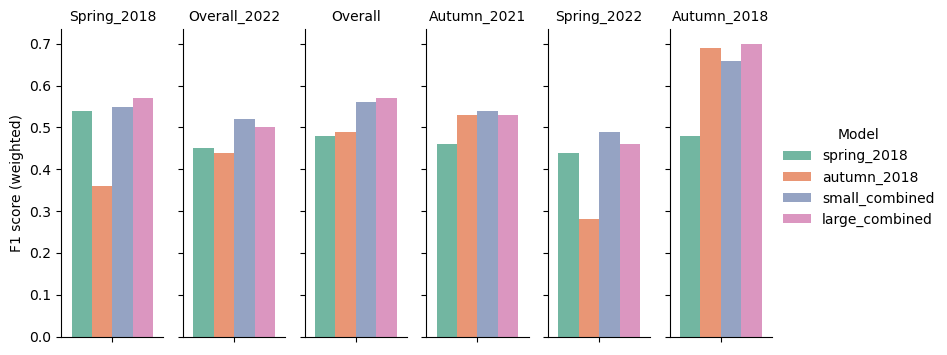

In [127]:
model_sorting = {'spring_2018':1,'autumn_2018':2,'small_combined':3,'large_combined':4}
dataset_sorting = {'Spring_2018':1,'Spring_2022':2,'Autumn_2018':3,'Autumn_2021':4,'Overall':5,'Overall_2022':6}
df_melted_sorted['model_sorting'] = df_melted_sorted['Model'].apply(lambda x: model_sorting[x])
df_melted_sorted['dataset_sorting'] = df_melted_sorted['Dataset'].apply(lambda x: dataset_sorting[x])
df_melted_sorted = df_melted_sorted.sort_values(by = 'model_sorting', ascending = True)

p = sns.catplot(data = df_melted_sorted, x='Measure',y='Score',hue='Model',col='Dataset',kind='bar',palette='Set2', height = 4, aspect = 1/3, margin_titles=False)
p.set_axis_labels('','F1 score (weighted)')
p.set_xticklabels('')
p.set_titles("{col_name}")

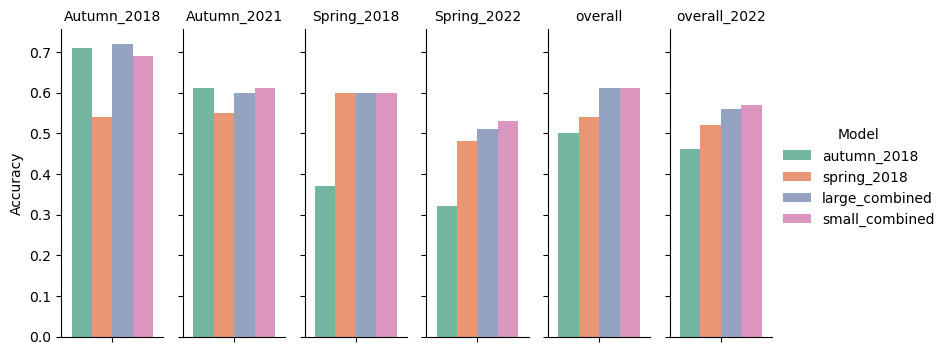

In [323]:
p = sns.catplot(data = df_melted[(df_melted['Measure'] == 'accuracy')], x='Measure',y='Score',hue='Model',col='Dataset',kind='bar',palette='Set2', height = 4, aspect = 1/3, margin_titles=False)
p.set_axis_labels('','Accuracy')
p.set_xticklabels('')
p.set_titles("{col_name}")

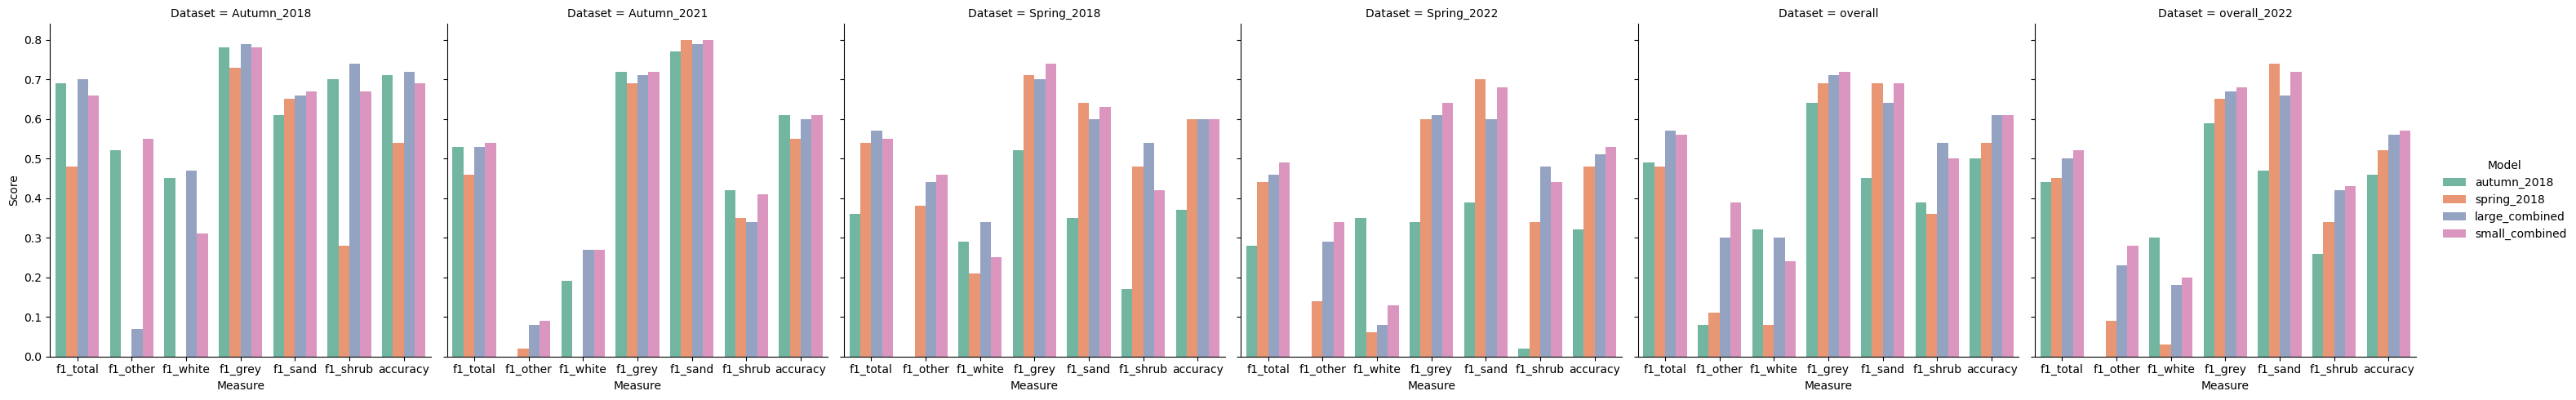

In [309]:
sns.catplot(data = df_melted[(df_melted['Measure'] != 'f1_total') | (df_melted['Measure'] != 'accuracy')], x='Measure',y='Score',hue='Model',col='Dataset',kind='bar',palette='Set2')